In [1]:
import sys
sys.path.append('../src')

In [2]:
%load_ext autoreload
%autoreload 2

In [15]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
import warnings

from data_preprocessing import convert_citibike_zip_to_parquet, load_parquet_in_spark, fetch_data

In [5]:
citibike_data_zip_path = '../data/raw/2023-citibike-tripdata.zip'
processed_data_output_path = '../data/processed/citibike/'

In [6]:
trip_data = load_parquet_in_spark(os.path.join(processed_data_output_path,'trips/'))
print(f"Total number of records: {trip_data.count()}")

Total number of records: 92075958


In [9]:
# Filter out trips outside OF 2021-2023 date range
trip_data = trip_data.withColumn("date", F.to_date("started_at"))
total_trips = trip_data.count()
trips_outside_range = trip_data.filter((F.col("date") < "2021-01-01") | (F.col("date") > "2023-12-31")).count()
percentage_outside_range = (trips_outside_range / (total_trips + trips_outside_range)) * 100
print(f"Number of trips outside the 2021-2024 range: {trips_outside_range} ({percentage_outside_range:.2f}%)")
print("We will discard these trips as we consider them outliers.")
trip_data = trip_data.filter((F.col("date") >= "2021-01-01") & (F.col("date") <= "2023-12-31"))

# Filter out trips with a duration shorter then 5 mins and longer than 300 mins
x_threshold = 300  # upper threshold
y_threshold = 5    # lower threshold
trip_data = trip_data.withColumn(
    "duration_minutes",
    F.round((F.unix_timestamp("ended_at") - F.unix_timestamp("started_at")) / 60).cast("integer")
)
total_trips = trip_data.count()
trips_longer_than_x = trip_data.filter(F.col("duration_minutes") > x_threshold).count()
trips_shorter_than_y = trip_data.filter(F.col("duration_minutes") < y_threshold).count()
percentage_longer_than_x = (trips_longer_than_x / total_trips) * 100
percentage_shorter_than_y = (trips_shorter_than_y / total_trips) * 100
print(f"Number of trips shorter than {y_threshold} minutes: {trips_shorter_than_y} ({percentage_shorter_than_y:.2f}%)")
print(f"Number of trips longer than {x_threshold} minutes: {trips_longer_than_x} ({percentage_longer_than_x:.2f}%)")
print("We will discard these trips as we consider them outliers.")
trip_data = trip_data.filter(
    (F.col("duration_minutes") >= y_threshold) & (F.col("duration_minutes") <= x_threshold)
)
print(f"Total number of filtered records: {trip_data.count()}")

Number of trips outside the 2021-2024 range: 1009 (0.00%)
We will discard these trips as we consider them outliers.
Number of trips shorter than 5 minutes: 15340021 (16.66%)
Number of trips longer than 300 minutes: 206815 (0.22%)
We will discard these trips as we consider them outliers.
Total number of filtered records: 76528113


In [10]:
# Group by date and calculate daily trip count and duration sum
citibike_trips_daily = trip_data.groupBy("date").agg(
    F.count("*").alias("trip_count"),
    F.sum("duration_minutes").alias("duration_sum")
)

# Convert to Pandas and set up
citibike_trips_daily_pd = citibike_trips_daily.orderBy("date").toPandas()
citibike_trips_daily_pd['date'] = pd.to_datetime(citibike_trips_daily_pd['date'])
citibike_trips_daily_pd.set_index('date', inplace=True)

In [12]:
#Aggregate daily data to weekly data
citibike_trips_weekly = citibike_trips_daily_pd['trip_count'].resample('W').sum()

C:\Users\azizt\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\azizt\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\azizt\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\azizt\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observation

Best SARIMA Parameters: ((2, 1, 1), (1, 0, 1, 52)) with Validation MAE: 56444.96


C:\Users\azizt\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Test MAE: 62997.80
Test MAPE: 13.77%


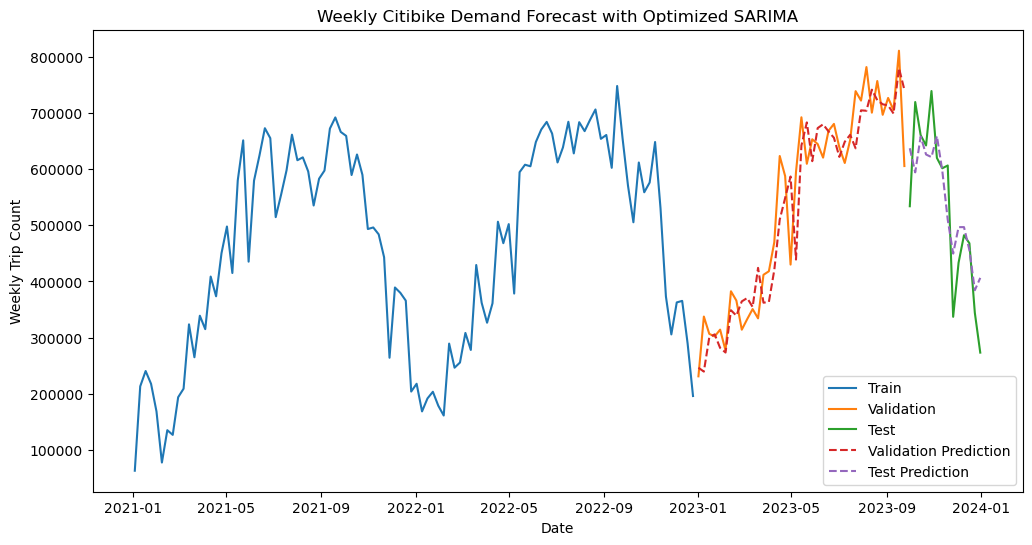

In [18]:
# Step 1: Resample data to weekly frequency
citibike_weekly = citibike_trips_daily_pd['trip_count'].resample('W').sum()

# Step 2: Train-Validation-Test Split
train = citibike_weekly[:'2022-12-31']
validation = citibike_weekly['2023-01-01':'2023-09-30']
test = citibike_weekly['2023-10-01':]

# Step 3: Hyperparameter Tuning with Grid Search on Validation Set
# Define parameter ranges
p = d = q = range(0, 3)  # (p, d, q) for non-seasonal part
P = D = Q = range(0, 2)  # (P, D, Q) for seasonal part
s = 52  # Weekly seasonality

# Generate all combinations of parameters
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], s) for x in itertools.product(P, D, Q)]

best_mae = float("inf")
best_params = None

# Grid search for best parameters
for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(train, order=param, seasonal_order=seasonal_param, enforce_stationarity=False, enforce_invertibility=False)
            results = model.fit(disp=False)
            # Forecast on validation set
            validation_forecast = results.get_forecast(steps=len(validation))
            validation_pred = validation_forecast.predicted_mean
            # Calculate MAE on validation set
            val_mae = mean_absolute_error(validation, validation_pred)
            
            # Check if this is the best model so far
            if val_mae < best_mae:
                best_mae = val_mae
                best_params = (param, seasonal_param)
                
        except Exception as e:
            continue  # If a model configuration fails, skip it

print(f"Best SARIMA Parameters: {best_params} with Validation MAE: {best_mae:.2f}")

# Step 4: Retrain on Combined Train + Validation Set with Best Parameters
combined_train_val = pd.concat([train, validation])
best_order, best_seasonal_order = best_params

model = SARIMAX(combined_train_val, order=best_order, seasonal_order=best_seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
sarima_model = model.fit(disp=False)

# Step 5: Forecast on Test Set
test_forecast = sarima_model.get_forecast(steps=len(test))
test_pred = test_forecast.predicted_mean

# Step 6: Evaluate on Test Set
test_mae = mean_absolute_error(test, test_pred)
test_mape = mean_absolute_percentage_error(test, test_pred)

print(f"Test MAE: {test_mae:.2f}")
print(f"Test MAPE: {test_mape * 100:.2f}%")

# Step 7: Visualization
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(validation.index, validation, label='Validation')
plt.plot(test.index, test, label='Test')
plt.plot(validation.index, sarima_model.predict(start=validation.index[0], end=validation.index[-1]), label='Validation Prediction', linestyle='--')
plt.plot(test.index, test_pred, label='Test Prediction', linestyle='--')
plt.title('Weekly Citibike Demand Forecast with Optimized SARIMA')
plt.xlabel('Date')
plt.ylabel('Weekly Trip Count')
plt.legend()
plt.show()

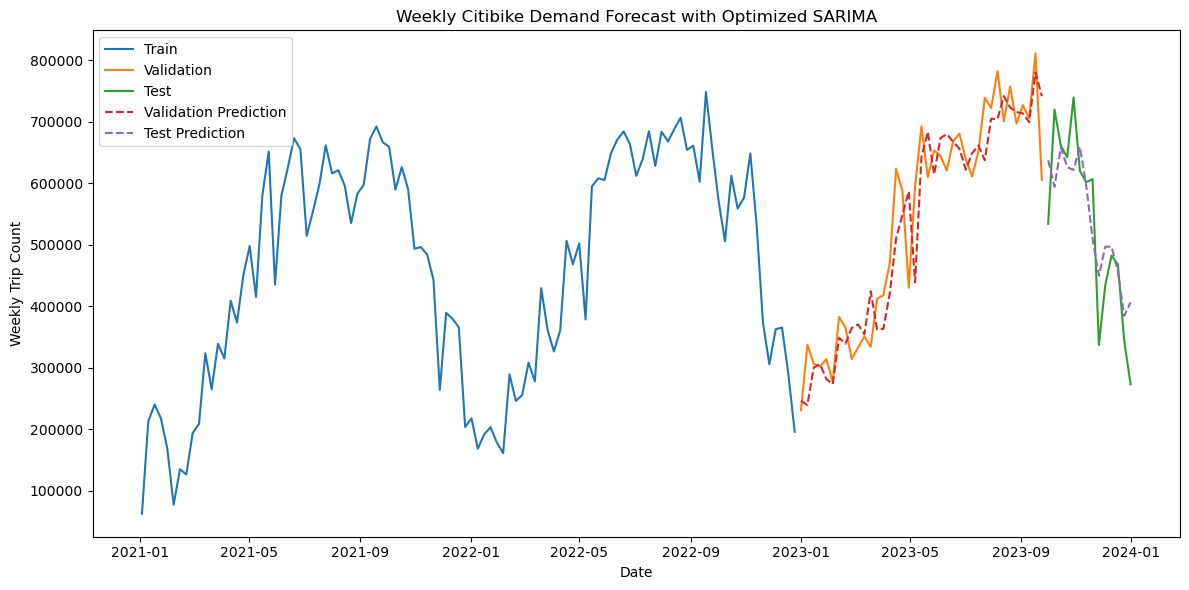

In [26]:
# Step 7: Visualization
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(validation.index, validation, label='Validation')
plt.plot(test.index, test, label='Test')
plt.plot(validation.index, sarima_model.predict(start=validation.index[0], end=validation.index[-1]), label='Validation Prediction', linestyle='--')
plt.plot(test.index, test_pred, label='Test Prediction', linestyle='--')
plt.title('Weekly Citibike Demand Forecast with Optimized SARIMA')
plt.xlabel('Date')
plt.ylabel('Weekly Trip Count')
plt.legend()
plt.tight_layout()
plt.savefig('../results/weekily_demand_forecast.jpg')
plt.show()